<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg"  width=400></p>

<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

In [25]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F

### 0. Fix data type and device for this notebook

In [26]:
# check for CUDA availability (NVIDIA GPU)
if torch.cuda.is_available():
    # get the CUDA device name
    device = torch.device('cuda')          # CUDA-device object
else:
    device = torch.device('cpu')           # cpu-device object

print(device)

cuda


In [27]:
# fix the data types for data (X) and label (y)

data_dtype = torch.float32
print('data_dtype:', data_dtype)

label_dtype = torch.int64
print('label_dtype:', label_dtype)

data_dtype: torch.float32
label_dtype: torch.int64


## Generate the data

In [28]:
# код для генерации взят из Стэнфордсокго курса:
# http://cs231n.github.io/neural-networks-case-study/#linear

N = 100
D = 2
K = 3
X = np.zeros((N * K, D))
y = np.zeros(N * K, dtype='uint8')

for j in range(K):
    ix = range(N * j,N * (j + 1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j * 4, (j + 1) * 4,N) + np.random.randn(N) * 0.2 # theta
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j

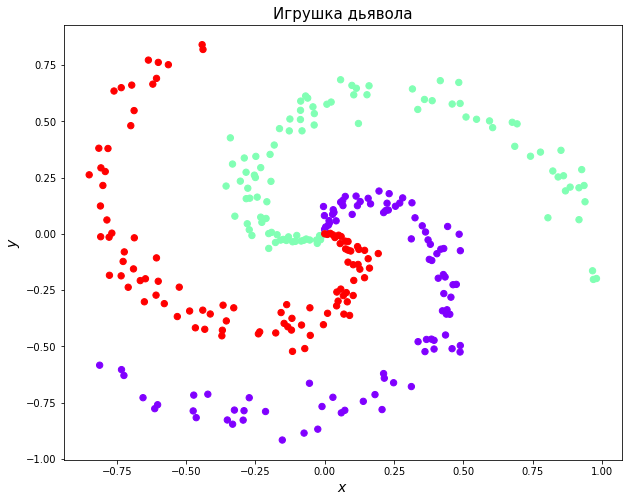

In [29]:
# Отрисовочная магия, снова взято из:
# http://cs231n.github.io/neural-networks-case-study/#linear

plt.figure(figsize=(10, 8))

plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)

plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

In [30]:
X = torch.tensor(X, dtype=data_dtype, device=device)
y = torch.tensor(y, dtype=label_dtype, device=device)

In [31]:
print("X.shape: ", X.shape)
print("y.shape: ", y.shape)
print()

print("X.dtype: ", X.dtype)
print("y.dtype: ", y.dtype)
print()

print("X.device: ", X.device)
print("y.device: ", y.device)
print()

print("X.requires_grad: ", X.requires_grad)
print("y.requires_grad: ", y.requires_grad)

X.shape:  torch.Size([300, 2])
y.shape:  torch.Size([300])

X.dtype:  torch.float32
y.dtype:  torch.int64

X.device:  cuda:0
y.device:  cuda:0

X.requires_grad:  False
y.requires_grad:  False


Сейчас мы хотим научиться самостоятельно создавать наследников nn.Module. До этого мы делали нейросети с помощью класса nn.Sequential, попробуем построить такую же сеть, как на прошлом семинаре, но самостоятельно.

In [32]:
# СЕТЬ С ПРОШЛОГО СЕМИНАРА

# D_in - размерность входа (количество признаков у объекта);
# H - размерность скрытых слоёв; 
# D_out - размерность выходного слоя (суть - количество классов)
D_in, H, D_out = 2, 100, 3

# Use the nn package to define our model and loss function.
two_layer_net = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.Softmax()
)

two_layer_net = two_layer_net.to(device)

Что такое модуль и как он устроен? Во-первых, модуль это такой строительный блок для нейронок, с помощью модуля можно задать любую дифференциируемую по своему параметру функцию. Применяются модули так же, как и обычные функции с синтаксисом
> module_instance(var1, var2)

При этом внутри вызывается функция forward с теми же аргументами, а ее выход возвращается как результат вызова модуля. Зачем же нужно так странно оборачивать обычные функции в модули? 

* Это позволяет очень удобно следить за параметрами, которые надо изменять. Когда мы хоти получить все параметры можно просто рекурсивно пройтись по всем полям модели, посмотреть, какие из ни параметры сами по себе, а какие являются модулями и содрежат параметры внутри, а потом все это собрать. 

_По этой причине если вы используете внутри своего модуля какие-то еще модули их надо класть просто в поле класса, если это единичный модуль, и в класс **nn.ModuleList** или **nn.ModuleDict**, если у вас список или словарь используемых модулей. Если же в модели у вас есть како-то собственный вес, то недостаточно положить тензор в поле класса, его надо обернуть в **nn.Parameter, nn.ParameterList** или **nn.ParameterDict** в зависимотси от того, что именно у вас._

* Такая организация позволяет достаточно безболезненно расширять PyTorch и писать для него свои функции, которые нельзя выразить композицией уже существующих. Пригождается это редко, поэтому сегодня мы не будем писать свое расширение.

* Код, разделенный на модули, это просто красиво.

In [38]:
# НОВАЯ СЕТЬ

class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.f_lin = nn.Linear(D_in, H)
        self.s_lin = nn.Linear(H, D_out)
        
    def forward(self, X):
        X = F.relu(self.f_lin(X))
        return F.softmax(self.s_lin(X))
    
model = MyModule()
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), 1e-1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


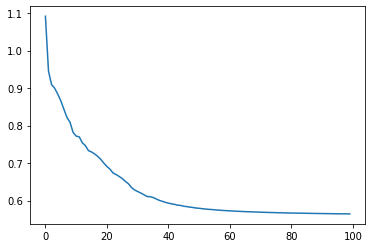

In [39]:
losses = []
for t in range(100):
    # forward
    y_pred = model(X)

    # calculate the loss
    loss = loss_fn(y_pred, y)

    # record the loss value
    losses.append(loss.item())

    # reset the gradients (set to 0)
    optim.zero_grad()

    # calculate the gradients
    loss.backward()

    # make a gradient step
    optim.step()
    
plt.plot(losses)

Теперь посмотрим, что будет, если не положить используемые внутри слои в self

In [40]:
# Сеть без параметров

class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layers = [nn.Linear(D_in, H), nn.Linear(H, D_out)]
        self.my_useless_bias = torch.ones(1, H, requires_grad=True)
        self.more_of_my_useless_biases = [
            torch.ones(1, H, requires_grad=True),
            torch.ones(1, H, requires_grad=True),
            torch.ones(1, H, requires_grad=True)
        ]
        
    def forward(self, X):
        X = F.relu(self.linear_layers[0](X))
        X += self.my_useless_bias
        return F.softmax(self.linear_layers[1](X))
    
model = MyModule()
model = model.to(device)

list(model.parameters())

[]

In [41]:
losses = []
for t in range(100):
    # forward
    y_pred = model(X)

    # calculate the loss
    loss = loss_fn(y_pred, y)

    # record the loss value
    losses.append(loss.item())

    # reset the gradients (set to 0)
    optim.zero_grad()

    # calculate the gradients
    loss.backward()

    # make a gradient step
    optim.step()
    
plt.plot(losses)

RuntimeError: ignored

Как мы и ожидали параметров нет. Исправим это.

In [42]:
# Исправленная сеть с параметрами

class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layers = nn.ModuleList([nn.Linear(D_in, H), nn.Linear(H, D_out)])
        self.my_useless_bias = nn.Parameter(torch.ones(1, H, requires_grad=True))
        self.more_of_my_useless_biases = nn.ParameterList([
            nn.Parameter(torch.ones(1, H, requires_grad=True)),
            nn.Parameter(torch.ones(1, H, requires_grad=True)),
            nn.Parameter(torch.ones(1, H, requires_grad=True))
        ])
        
    def forward(self, X):
        X = F.relu(self.linear_layers[0](X))
        X += self.my_useless_bias
        for b in self.more_of_my_useless_biases:
            X += b
        return F.softmax(self.linear_layers[1](X))


model = MyModule()
model = model.to(device)

list(model.parameters())

[Parameter containing:
 tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], device='cuda:0',
        requires_grad=True), Parameter containing:
 tensor([[-0.2398, -0.5338],
         [ 0.1960, -0.1743],
         [-0.1073,  0.0265],
         [-0.5042,  0.2905],
         [-0.1138, -0.1003],
         [ 0.3388,  0.3596],
         [ 0.6472,  0.1244],
         [ 0.4842, -0.3392],
         [-0.0281,  0.2181],
         [ 0.3244,  0.6444],
         [ 0.2794, -0.1740],
         [ 0.2162, -0.0650],
         [ 0.5926, -0.2422],
         [-0.6898, -0.6570],
         [-0.1549,  0.4500],
         [ 0

Как мы и хотели, все параметры появились